## 1. Descripción del dataset

El dataset a tratar en la práctica es  https://www.kaggle.com/datasets/rashikrahmanpritom/heart-attack-analysis-prediction-dataset.

Se trata de un dataset con 14 variables, las cuales estan asociadas a pacientes con síntomas coronarios y cuyo objetivo es la predicción de la probabilidad (mayor o menor) de tener un ataque al corazón bajo esos síntomas. El dataset es de mucha relevancia, dado que poder entrerar un modelo que anticipe esta circunstancia podría ayudar a salvar muchas vidas. 

El dataset consta de las siguientes variables:
- **age** : Edad del paciente
- **sex**: Sexo del paciente, 1: Hombre, 0: Mujer
- **cp** : Chest Pain type chest pain type. Tipo de dolor en el pecho. Puede tomar los valores:
    - Valor 0: typical angina
    - Valor 1: atypical angina
    - Valor 2: non-anginal pain
    - Valor 3: asymptomatic
     
    > Aunque en el dataset de referenca de Kaggle de indica que el rango de valores de la variable es [1..4],  analizando el fichero se observa que es [0..3]
    
- **trtbps** : resting blood pressure (in mm Hg). Presion sanguinea en reposo.
- **chol** : cholestoral in mg/dl fetched via BMI sensor. Colesterol en sangre.
- **fbs** : (fasting blood sugar > 120 mg/dl) (1 = true; 0 = false). Azúcar en sangre en ayunas por encima de 129 mg/dl. Codificado como 1 Verdadero, 0 Falso.
- **restecg** : resting electrocardiographic results. Resultados del electrocardiograma en reposo. Puede tomar los siguientes valores:
    - Valor 0: normal
    - Valor 1: having ST-T wave abnormality (T wave inversions and/or ST elevation or depression of > 0.05 mV)
    - Valor 2: showing probable or definite left ventricular hypertrophy by Estes' criteria.

- **thalachh** : maximum heart rate achieved. Frecuencia cardiaca máxima.
- **exng**:  "exercise induced angina". Angina inducida por el ejercicio. Codificado como 1 "Si" 0 "No".
- **caa**: number of major vessels. Numero de vasos sanguineos mayores. Codificado de 0 a 4. 

    > En la descripción del dataset de Kaggle se indica que que el rango de la variable es 0..3, sin embargo observando el fichero, se codifica de 0..4. Esto es mas coherente, ya que los vasos mayores del corazón son 5.
    
- **output** :  Variable objetivo. 0 = menor posibilidad de ataque al corazón 1 = mayor posibilidad de ataque al corazon.

El dataset consta de otras tres variables que no están descritas y no conocemos su significado (oldpeak, slp y thall) que no utilizaremos por pruedencia.

A continuación, vamos a visualizar los primeros datos del dataset

In [1]:
import warnings
import pandas as pd
from matplotlib import pyplot as plt, colors

warnings.filterwarnings('ignore')

raw_data = pd.read_csv("./datos/heart.csv")
df = raw_data.copy()
df.head()

,age,sex,cp,trtbps,chol,fbs,restecg,thalachh,exng,oldpeak,slp,caa,thall,output
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


## 2. Integración y selección

El dataset contiene toda la información necesaria por sí mismo, sin necesidad de integrarlo con otras fuentes.

Sin embargo, vamos a integrarlo con ficheros que contienen las descripciones de los campos categoricos del dataset, de manera que sea más fácil su interpretación y trabajo con los datos.

Después de la integración de cada fichero, borraremos la columna de cruce del fichero integrado, para no duplicar la columna.

#### Exang

In [2]:
df_exang = pd.read_csv("./datos/exang.csv")

In [3]:
df = df.merge(df_exang, how="left", left_on="exng", right_on="id_exang").drop(["id_exang"], axis=1)

#### Chest pain

In [4]:
df_cp = pd.read_csv("./datos/chest_pain.csv")

In [5]:
df = df.merge(df_cp, left_on="cp", right_on="id_cp", how="left").drop(["id_cp"], axis=1)

#### Fasting Blood Sugar

In [6]:
df.loc[df.fbs == 1, 'desc_fbs'] = 'Fasting Blood Sugar > 120 mg/dl'
df.loc[df.fbs == 0, 'desc_fbs'] = 'Fasting Blood Sugar < 120 mg/dl'

#### Sex

In [7]:
df.loc[df.sex == 1, 'desc_sex'] = 'Man'
df.loc[df.sex == 0, 'desc_sex'] = 'Woman'

#### ResteCG


In [8]:
df.loc[df.restecg == 2, 'desc_restecg'] = 'Left Ventricular atrophy'
df.loc[df.restecg == 1, 'desc_restecg'] = 'ST-T Wave abnormality'
df.loc[df.restecg == 0, 'desc_restecg'] = 'Normal'

#### Output

In [9]:
df.loc[df.output == 1, 'desc_output'] = 'High heart attack risk'
df.loc[df.output == 0, 'desc_output'] = 'Low heart attack risk'

Borramos las columnas que no vamos a utilizar:

In [10]:
df = df.drop(["oldpeak", "slp", "thall"], axis=1)

Visualizamos el dataset final una vez generadas todas las descripciones para columnas categóricas.

## 3. Limpieza de los datos.

### - Valores nulos

Obenemos un listado de las columnas que tienen nulos y el porcentaje que representan sobre el total de datos.

In [11]:
df.apply(lambda x: sum(x.isnull())/len(x))

age             0.0
sex             0.0
cp              0.0
trtbps          0.0
chol            0.0
fbs             0.0
restecg         0.0
thalachh        0.0
exng            0.0
caa             0.0
output          0.0
desc_exang      0.0
desc_cp         0.0
desc_fbs        0.0
desc_sex        0.0
desc_restecg    0.0
desc_output     0.0
dtype: float64

Como vemos, no existen valores nulos que representen pérdida de información.

### - Valores extremos

En el análisis de valores extremos nos fijaremos en las siguientes variables, ya que son las que tienen dominios contínuos y para las que tiene sentido realizar este análisis.

In [12]:
features = ["trtbps","chol","age","thalachh"]

#### Análisis univariante

Para detectar los outliers univariantes, realizamos un box plot y buscamos puntos identificados como atípicos. Dado que no disponemos de muchos datos, en vez de eliminarlos, una vez identificados los marcaremos como Null e imputaremos utilizando kNN. De esta manera podremos obtener distribuciones más normales para los análisis posteriores del apartado 5.

**Identificación de valores extremos**

<AxesSubplot: >

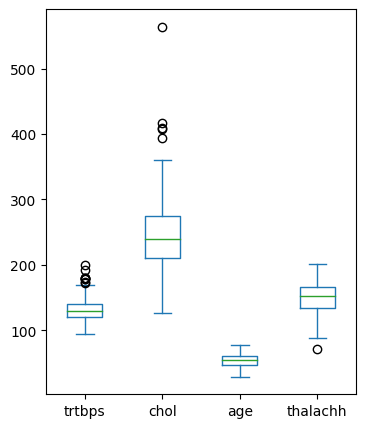

In [13]:
df[features].plot.box(figsize=(4,5))

Imprimimos los valores atípicos:

In [14]:
from matplotlib.cbook import boxplot_stats

stats_boxplot = list(zip(features, boxplot_stats(df[features])))

_ = [print(feature, stats["fliers"]) for feature, stats in stats_boxplot]

trtbps [172 178 180 180 200 174 192 178 180]
chol [417 564 394 407 409]
age []
thalachh [71]


**Eliminación de valores extremos**

In [15]:
for feature, stats in stats_boxplot:
    for stat in stats["fliers"]:
        df[feature].replace({stat: None}, inplace=True)

**Imputación de valores extremos**

Utilizamos KNN para imputar valores eliminados.

In [16]:
from sklearn.impute import KNNImputer

imputer = KNNImputer(n_neighbors=5)
df[features] = imputer.fit_transform(df[features])

df[features] = pd.DataFrame(df, columns=df[features].columns)
df.head()

,age,sex,cp,trtbps,chol,fbs,restecg,thalachh,exng,caa,output,desc_exang,desc_cp,desc_fbs,desc_sex,desc_restecg,desc_output
0,63.0,1,3,145.0,233.0,1,0,150.0,0,0,1,no,asymptomatic,Fasting Blood Sugar > 120 mg/dl,Man,Normal,High heart attack risk
1,37.0,1,2,130.0,250.0,0,1,187.0,0,0,1,no,non-anginal pain,Fasting Blood Sugar < 120 mg/dl,Man,ST-T Wave abnormality,High heart attack risk
2,41.0,0,1,130.0,204.0,0,0,172.0,0,0,1,no,atypical angina,Fasting Blood Sugar < 120 mg/dl,Woman,Normal,High heart attack risk
3,56.0,1,1,120.0,236.0,0,1,178.0,0,0,1,no,atypical angina,Fasting Blood Sugar < 120 mg/dl,Man,ST-T Wave abnormality,High heart attack risk
4,57.0,0,0,120.0,354.0,0,1,163.0,1,0,1,yes,typical angina,Fasting Blood Sugar < 120 mg/dl,Woman,ST-T Wave abnormality,High heart attack risk


Ahora podemos comprobar mediante un Box Plot que ya no obtenemos valores extremos mediante análisis univariante.

<AxesSubplot: >

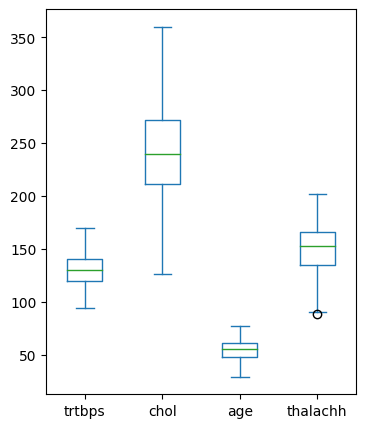

In [17]:
df[features].plot.box(figsize=(4,5))

#### Análisis multivariante

El siguiente paso será verificar si existen valores extremos mediante análisis multivariante. Esto nos permitirá identificar los puntos que se encuentran muy alejados del conjunto global de los datos y realizar un tratamiento sobre ellos si se requiere.

Para identificar los valores extremos, realizaremos una clusterización utilizando OPTICS. El primer paso para ello será escalar los datos, utilizaremos MinMax.

In [18]:
from sklearn.preprocessing import MinMaxScaler

scaled = MinMaxScaler().fit_transform(df[features])

df_scaled = pd.DataFrame(scaled, columns=features)

Number of clusters:  9


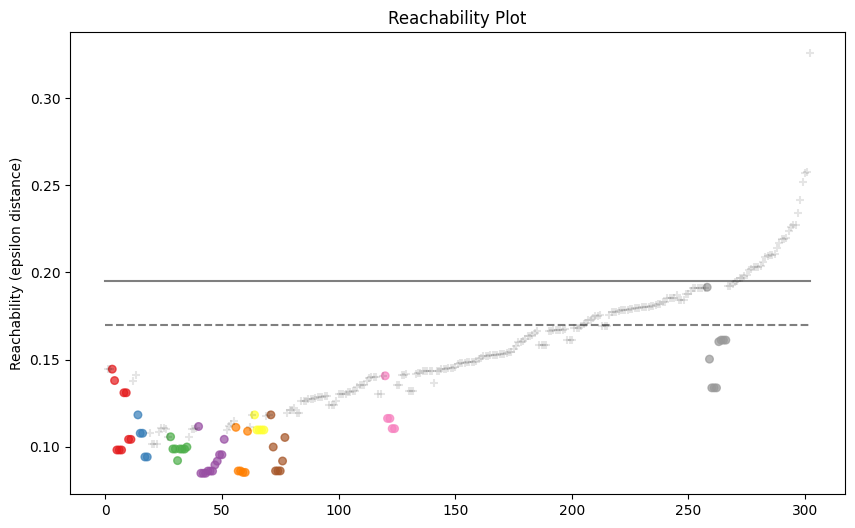

In [19]:
import numpy as np

from sklearn.cluster import OPTICS, cluster_optics_dbscan

cut_line_1 = .17# .19
cut_line_2 = .195# .22

clust= OPTICS().fit(df_scaled)

space = np.arange(len(df_scaled))
reachability = clust.reachability_[clust.ordering_]
labels = clust.labels_[clust.ordering_]

# Normalización de las etiquetas para obtener los colores de los clusters
norm = colors.Normalize(vmin=0, vmax=max(labels))

plt.figure(figsize=(10, 6))

# Plot datos normales
plt.scatter(space[labels!=-1], reachability[labels!=-1], c=labels[labels!=-1], norm=norm, s=30, cmap="Set1", alpha=.7)
# Plot atipicos
plt.scatter(space[labels==-1], reachability[labels==-1], c="black", s=30, alpha=.1, marker="+")

# Lineas de corte de extracción eps
plt.plot(space, np.full_like(space, cut_line_1, dtype=float), "k--", alpha=0.5)
plt.plot(space, np.full_like(space, cut_line_2, dtype=float), "k-", alpha=0.5)

plt.ylabel("Reachability (epsilon distance)")
plt.title("Reachability Plot")

print("Number of clusters: ",labels.max()+1)

Situamos dos lineas de corte para la extracción de los clusters. Una por encima del último cluster en la que la pendiente de los atipicos se vuelve más empinada (donde sólo analizaremos los datos atípicos mas solitarios) y otra justo por debajo del último cluster, para poder comparar los atípicos que extraemos asumiendo que el último cluster es ya extraño.

In [20]:
def extract_cluster_dbscan_eps(eps):
    labels = cluster_optics_dbscan(
        reachability=clust.reachability_,
        core_distances=clust.core_distances_,
        ordering=clust.ordering_,
        eps=eps
    )
        
    return labels

In [21]:
labels_1 = extract_cluster_dbscan_eps(cut_line_1)
labels_2 = extract_cluster_dbscan_eps(cut_line_2)

df["atipico_1"] = labels_1 == -1
df["atipico_2"] = labels_2 == -1

print("Number of clusters atipico_1: ",labels_1.max() + 1)
print("Number of clusters atipico_2: ",labels_2.max() + 1)

Number of clusters atipico_1:  3
Number of clusters atipico_2:  1


Como vemos, en el segundo nivel obtenemos un cluster de valores normales (atípico_2). A continuación, visualizamos los registros que se quedan fuera, que se identifican como outliers:

In [22]:
df.loc[df.atipico_2 == True].head()

,age,sex,cp,trtbps,chol,fbs,restecg,thalachh,exng,caa,output,desc_exang,desc_cp,desc_fbs,desc_sex,desc_restecg,desc_output,atipico_1,atipico_2
39,65.0,0,2,160.0,360.0,0,0,151.0,0,0,1,no,non-anginal pain,Fasting Blood Sugar < 120 mg/dl,Woman,Normal,High heart attack risk,True,True
44,39.0,1,2,140.0,321.0,0,0,182.0,0,0,1,no,non-anginal pain,Fasting Blood Sugar < 120 mg/dl,Man,Normal,High heart attack risk,True,True
53,44.0,0,2,108.0,141.0,0,1,175.0,0,0,1,no,non-anginal pain,Fasting Blood Sugar < 120 mg/dl,Woman,ST-T Wave abnormality,High heart attack risk,True,True
60,71.0,0,2,110.0,265.0,1,0,130.0,0,1,1,no,non-anginal pain,Fasting Blood Sugar > 120 mg/dl,Woman,Normal,High heart attack risk,True,True
63,41.0,1,1,135.0,203.0,0,1,132.0,0,0,1,no,atypical angina,Fasting Blood Sugar < 120 mg/dl,Man,ST-T Wave abnormality,High heart attack risk,True,True


Eliminaremos estos registros para que no desvirtúen los análisis estadísticos posteriores. Dado que son outliers multivariantes, no podemos imputarlos por KNN.

In [23]:
data = df.loc[df.atipico_2 == False]
data = data.drop(columns = ["atipico_1", "atipico_2"], axis = 1)

## 4. Análisis de los datos y representación de resultados

### 4.1 Selección de las variables a analizar

Las variables que vamos a analizar son:
- age (edad)
- sex (sexo)
- trtbps (presión sanguinea en reposo)
- chol (colesterol en sangre)
- thallachh (pulsaciones máximas)

El objetivo es determinar si existe correlación entre las variables numéricas y si a partir de ellas podemos realizar una modelo de Regresión que prediga la variable objetivo. También verificaremos que si el sexo presenta diferencias estadísticas con respecto a las otras variables y así realizar estudios separados.

Antes de todo, realizaremos pruebas de normalidad y homocedasticidad a las variables numéricas, para determinar qué tipo de análisis estadístico realizaremos.

### 4.2 Análisis de normalidad y homogeneidad de la varianza

#### Test de normalidad

In [24]:
from scipy.stats import shapiro

def shapiro_test_normality(data, col):
    stat, pvalue = shapiro(data)
    print(f"Result for {col}:")
    print("stat: %.9f, p: %.9f" % (stat, pvalue))
    if pvalue > 0.05:
        dist = "Gaussian"
    else:
        dist = "Non-gaussian"
    print(f"{dist} distribution\n")

In [25]:
for col in features:
    shapiro_test_normality(data[col], col)

Result for trtbps:
stat: 0.987968802, p: 0.023374792
Non-gaussian distribution

Result for chol:
stat: 0.987562001, p: 0.019403134
Non-gaussian distribution

Result for age:
stat: 0.979144812, p: 0.000531145
Non-gaussian distribution

Result for thalachh:
stat: 0.970483959, p: 0.000022058
Non-gaussian distribution



Para todas las variables excepto el colesterol, el valor pvalue del test de Shapiro es menor a 0.05, lo que implica que no hay normalidad. 

Deberemos transformar los datos antes de comprobar la correlación (Pearson) con las demás variables. Para ello, utilizaremos la transformación de Box-Cox.

#### Transformación de BoxCox

In [26]:
from scipy.stats import boxcox

def boxcox_transform(data, col):
    fitted_data, fitted_lambda = boxcox(data)
    shapiro_test_normality(fitted_data, col)
    return fitted_data

In [27]:
for col in features:
    transformed_col = f"{col}_transformed"
    tranformed_data  = boxcox_transform(data[col], transformed_col)
    data[transformed_col] = tranformed_data

Result for trtbps_transformed:
stat: 0.988067746, p: 0.024461061
Non-gaussian distribution

Result for chol_transformed:
stat: 0.994258285, p: 0.397179812
Gaussian distribution

Result for age_transformed:
stat: 0.983332992, p: 0.002980971
Non-gaussian distribution

Result for thalachh_transformed:
stat: 0.989882052, p: 0.056595057
Gaussian distribution



Como vemos, tan solo thalachh_transformed y chol_transformed siguen una distribución normal a pesar de la transformación box-cox. 

Para realizar fine-tunning vamos a dibujar las distribuciones antes y después de la tranformación para identificar el problema y decidir los próximos pasos a seguir.

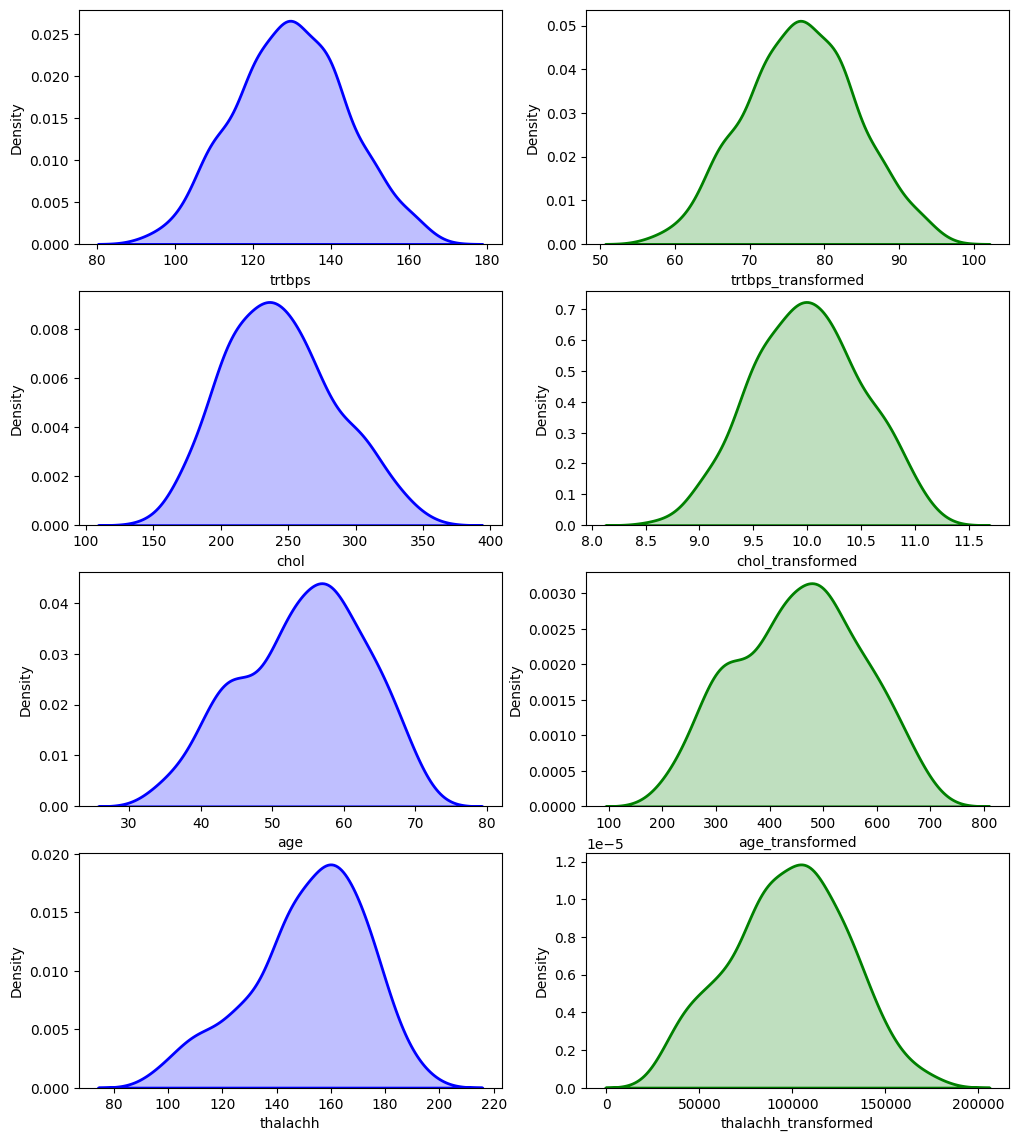

In [28]:
import matplotlib.pyplot as plt
import seaborn as sns

extended_features = []

fig, ax = plt.subplots(len(features), 2)

for idx, col in enumerate(features):
    transformed_col = f"{col}_transformed"

    sns.distplot(data[col], hist = False, kde = True,\
                    kde_kws = {'shade': True, 'linewidth': 2}, \
                    label = "Original data", color ="blue", ax = ax[idx][0])
    sns.distplot(data[transformed_col], hist = False, kde = True, \
                    kde_kws = {'shade': True, 'linewidth': 2},\
                    label = "Transformed data", color ="green", ax = ax[idx][1])

    extended_features.append(col)
    extended_features.append(transformed_col)

# rescaling the subplots
fig.set_figheight(14)
fig.set_figwidth(12)

A pesar de que el test de shapiro nos está dando valores muy bajos de p-value, observando la distribución se aprecia una tendencia muy similar a la normal para la columna trtbps. Si bien es cierto que las 4 variables tienen un pequeño pico (especialmente significativo para la edad) alrededor del primer tercio del eje X.

Habiendo visto en estos gráficos que la distribución no es totalmente desordenada y su cercanía a una normal, vamos a realizar un segundo test (Kolmogorov-Smirnov) y en función de sus resultados proseguiremos con los análisis asumiendo o no la normalidad de las variables.

In [29]:
from scipy.stats import kstest, norm

def ks_test_normality(data, col):
    loc, scale = norm.fit(data)
    n = norm(loc = loc, scale = scale)
    stat, pvalue = kstest(data, n.cdf)
    print(f"Result for {col}:")
    print("stat: %.9f, p: %.9f" % (stat, pvalue))
    if pvalue > 0.05:
        dist = "Gaussian"
    else:
        dist = "Non-gaussian"
    print(f"{dist} distribution\n")

In [30]:
print("### Testing with Kolmogorov-Smirnov  ###")

_ = [ks_test_normality(data[col], col) for col in extended_features if col.__contains__('_transformed')]   

### Testing with Kolmogorov-Smirnov  ###
Result for trtbps_transformed:
stat: 0.067830938, p: 0.157730868
Gaussian distribution

Result for chol_transformed:
stat: 0.030951608, p: 0.950327803
Gaussian distribution

Result for age_transformed:
stat: 0.060865668, p: 0.257307604
Gaussian distribution

Result for thalachh_transformed:
stat: 0.045024898, p: 0.625381413
Gaussian distribution



Obtenemos p-values suficientemente significativos para que, junto con los resultados de los gráficos, consideremos todas las variables transformadas normales excepto por la edad.

Para acabar de estudiar la distribución de la edad vamos a estudiar si, tratando las poblaciones por género de forma separada, se verifica la condición de normalidad. 

In [31]:
print("Shapiro-Wilk:\n")
print("Sex: Female")
shapiro_test_normality(data[data.sex == 0]["age_transformed"], "age_transformed")

print("Sex: Male")
shapiro_test_normality(data[data.sex == 1]["age_transformed"], "age_transformed")

print("Kolmogorov-Smirnov:\n")

print("Sex: Female")
ks_test_normality(data[data.sex == 0]["age_transformed"], "age_transformed")

print("Sex: Male")
ks_test_normality(data[data.sex == 1]["age_transformed"], "age_transformed")

Shapiro-Wilk:

Sex: Female
Result for age_transformed:
stat: 0.974823117, p: 0.094702177
Gaussian distribution

Sex: Male
Result for age_transformed:
stat: 0.983098745, p: 0.024106009
Non-gaussian distribution

Kolmogorov-Smirnov:

Sex: Female
Result for age_transformed:
stat: 0.091913449, p: 0.442962663
Gaussian distribution

Sex: Male
Result for age_transformed:
stat: 0.062685826, p: 0.440040770
Gaussian distribution



Si bien los p-value de K-S indican que sí que tiene una distribución Gaussiana, teniendo en cuenta el resultado de Shapiro-Wilk (que suele considerarse más robusto) y el gráfico anterior, resulta razonable no considerarla normal en global. Sí podríamos considerar una distribución normal para el sexo femenino.

Además, esto nos permitirá poner en práctica técnicas no paramétricas para este tipo de variables. Por lo tanto, consideramos los siguientes tipos de variables:

In [32]:
normal_features = ["thalachh_transformed", "chol_transformed", "trtbps_transformed"]
abnormal_features = ["age"]

#### Homogeneidad de la varianza para distribuciones normales

Para distribuciones normales, se suele utilizar el test de Levene para determinar su homocedasticidad. Vamos a excluir la variable *age* de este análisis ya que como hemos indicado en el apartado anterior, no sigue una distribución normal.

In [33]:
from sklearn.preprocessing import StandardScaler

std_scaler = MinMaxScaler()

scaled_data = std_scaler.fit_transform(data[extended_features].to_numpy())
scaled_data = pd.DataFrame(scaled_data, columns=extended_features)

In [34]:
from scipy.stats import levene


def levene_test_homocedasticity(df: pd.DataFrame, extended_cols: list, mode: str = 'mean'):
    transformed_fields = [col for col in extended_cols if col.__contains__('_transformed')]
    for first_field in transformed_fields:
        transformed_fields.remove(first_field)
        for second_field in transformed_fields:
            stat, pvalue = levene(df[first_field], df[second_field], center=mode)
            print("stat: %.3f, p: %.3f" % (stat, pvalue))
            if pvalue > 0.05:
                dist = f"Homocedasticity between {first_field} and {second_field}"
            else:
                dist = f"Non-Homocedasticity between {first_field} and {second_field}"
            print(dist)

In [35]:
levene_test_homocedasticity(scaled_data, normal_features)

stat: 2.251, p: 0.134
Homocedasticity between thalachh_transformed and chol_transformed
stat: 2.461, p: 0.117
Homocedasticity between thalachh_transformed and trtbps_transformed
stat: 0.011, p: 0.915
Homocedasticity between trtbps_transformed and chol_transformed


#### Homogeneidad de la varianza para distribuciones no normales

Para medir la homocedasticidad de *age*, utilizaremos el test de Fligner-Killeen, que es la alternativa no-paramétrica del test de Levene

In [36]:
from scipy.stats import fligner

def fligner_test_homocedasticity(df: pd.DataFrame, extended_cols: list, mode: str = 'mean'):
    transformed_fields = [col for col in extended_cols if col.__contains__('_transformed')]
    for first_field in ['age_transformed']:
        transformed_fields.remove(first_field)
        for second_field in transformed_fields:
            stat, pvalue = fligner(df[first_field], df[second_field])
            print("stat: %.3f, p: %.3f" % (stat, pvalue))
            if pvalue > 0.05:
                dist = f"Homocedasticity between {first_field} and {second_field}"
            else:
                dist = f"Non-Homocedasticity between {first_field} and {second_field}"
            print(dist)

In [37]:
fligner_test_homocedasticity(scaled_data, extended_features)

stat: 10.817, p: 0.001
Non-Homocedasticity between age_transformed and trtbps_transformed
stat: 10.787, p: 0.001
Non-Homocedasticity between age_transformed and chol_transformed
stat: 2.794, p: 0.095
Homocedasticity between age_transformed and thalachh_transformed


El p-value es  mayor que 0.05 para las variables transformadas de *age* y *thalachh*, por lo que son homogéneas en la varianza. Sin embargo, para el resto de variables no se cumple la condición de homocedasticidad, por lo que deberemos usar métodos estadísticos no paramétricos para ellas.

#### Resumen de variables y sus distribuciones:
- **age**: Tiene una distribución no normal pero presenta homogeneidad de la varianza respecto al resto de variables.
- **trtbps**: Tiene una distribución normal y presenta homogeneidad de la varianza respecto al resto de variables.
- **chol**: Tiene una distribución normal y presenta homogeneidad de la varianza respecto al resto de variables.
- **thallachh**: Tiene una distribución normal y presenta homogeneidad de la varianza respecto al resto de variables.

Con estos resultados obtenidos podemos dar paso a los análisis estadísticos.

### 4.3 Aplicación de pruebas estadísticas

En este apartado vamos a realizar varias pruebas estadísticas para entender de qué manera se relacionan y qué patrones existen en el conjunto de datos entre las diferentes variables. El objetivo de los análisis es determinar si la variable sexo puede ser relevante para la predicción o si la podemos omitir. 

Para ello, vamos a utilizar el test t de Student para analizar las diferentes variables para las dos poblaciones segregadas por sexo y, en función del p-value, determinaremos si existen diferencias significativas en las distribuciones de las dos poblaciones. En el caso de que existan, deberemos introducir el sexo en el modelo, ya que si no estaríamos omitiendo información relevante al modelo para resolver las variables que muestran diferentes distribuciones en función del sexo.

También estudiaremos la correlación entre las variables para estudiar la posibilidad de reducir dimensionalidad eliminando variables con correlaciones altas.

Y por último, realizaremos una regresión para comprobar la capacidad predictiva de un análisis que se realizara con este conjunto de variables.

#### Prueba t de Student

In [38]:
from scipy.stats import ttest_ind, mannwhitneyu

Antes de aplicar el test t de Student, debemos validar la normalidad de ambas poblaciones para las variables trtbps_transformed, chol_transformed y thalachh_transformed.

In [39]:
data.reset_index(drop=True, inplace = True)

for col in normal_features:
    print("Sex: Male")
    ks_test_normality(scaled_data[data.sex==1][col], col)
    print("Sex: Female")
    ks_test_normality(scaled_data[data.sex==0][col], col)

Sex: Male
Result for thalachh_transformed:
stat: 0.044975478, p: 0.829445810
Gaussian distribution

Sex: Female
Result for thalachh_transformed:
stat: 0.109395062, p: 0.242640618
Gaussian distribution

Sex: Male
Result for chol_transformed:
stat: 0.030344669, p: 0.993581265
Gaussian distribution

Sex: Female
Result for chol_transformed:
stat: 0.062999381, p: 0.867339388
Gaussian distribution

Sex: Male
Result for trtbps_transformed:
stat: 0.088304102, p: 0.103494215
Gaussian distribution

Sex: Female
Result for trtbps_transformed:
stat: 0.118297634, p: 0.170887096
Gaussian distribution



Obtenemos distribuciones normales, por lo que podemos usar el método de Levene para verificar la homocedasticidad.

In [40]:
for col in normal_features:
    print(col)
    print(levene(scaled_data[data.sex==1][col],
             scaled_data[data.sex==0][col]))

thalachh_transformed
LeveneResult(statistic=6.018657972370042, pvalue=0.014790262272021371)
chol_transformed
LeveneResult(statistic=0.8017279773651682, pvalue=0.37137774120367983)
trtbps_transformed
LeveneResult(statistic=0.04732589681510533, pvalue=0.8279484363707992)


Tanto el nivel de colesterol como la presión verifican la condición de homocedasticidad. No es el caso para las pulsaciones máximas (*thalachh*), por lo que para este último deberemos usar una alternativa no paramétrica de t de Student, en este caso utilizaremos el test de Mann Whitney U.

#### T de Student

In [41]:
print(ttest_ind(scaled_data[data.sex==1]['trtbps_transformed'],
                scaled_data[data.sex==0]['trtbps_transformed']))

Ttest_indResult(statistic=-0.7941772314752226, pvalue=0.42779230832110915)


In [42]:
print(ttest_ind(scaled_data[data.sex==1]['chol_transformed'],
                scaled_data[data.sex==0]['chol_transformed']))

Ttest_indResult(statistic=-2.808048625690822, pvalue=0.005349344703139816)


In [43]:
print(mannwhitneyu(scaled_data[data.sex==1]['thalachh_transformed'],
                scaled_data[data.sex==0]['thalachh_transformed']))

MannwhitneyuResult(statistic=7297.5, pvalue=0.3105008237437822)


Como vemos, la variable colesterol es la única que no supera el test, por lo que efectivamente muestra distribuciones diferentes según el sexo. Por lo que al analizar las correlaciones, o introducir esta variable en el modelo, debemos siempre segregarla por sexo, ya que proviene de poblaciones diferentes.

#### Matriz de correlación de Pearson para variables normales y homocedasticas

A continuación vamos a calcular las matrices de correlación para algunas de las las variables *feature*. En el caso de las variables que presentan distribuciones normales, podemos usar el coeficiente de Pearson. 

Tomando en cuenta los resultados obtenidos en el apartado anterior, excluiremos también el colesterol de la matriz de correlación ya que no tiene sentido tomar esta variable sin hacer la separación por sexo.

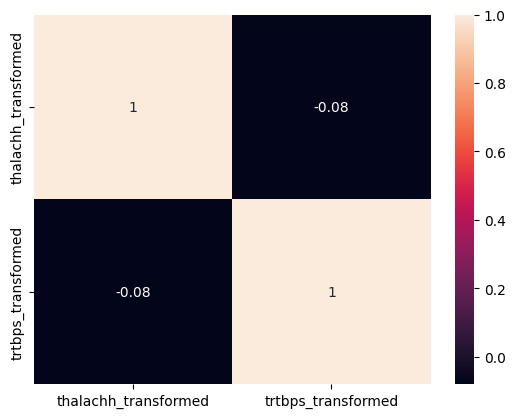

In [44]:
matrix = scaled_data[['thalachh_transformed', 'trtbps_transformed']].corr(method='pearson').round(2)
sns.heatmap(matrix, annot=True)
plt.show()

Como cabía esperar, no existe una gran correlación entre la presión sanguínea y las pulsaciones máximas, por lo que son dos buenas candidatas a introducir en el modelo ya que no son redundantes entre sí.

#### Matriz de correlación de Spearman para variables no normales y homocedasticas

Para la edad, calculamos una nueva matriz de correlación, esta vez aplicamos el método de Spearman, que es una alternativa al de Pearson no paramétrica que funciona también para variables que no siguen un distribución normal, que es el caso del campo *age*.

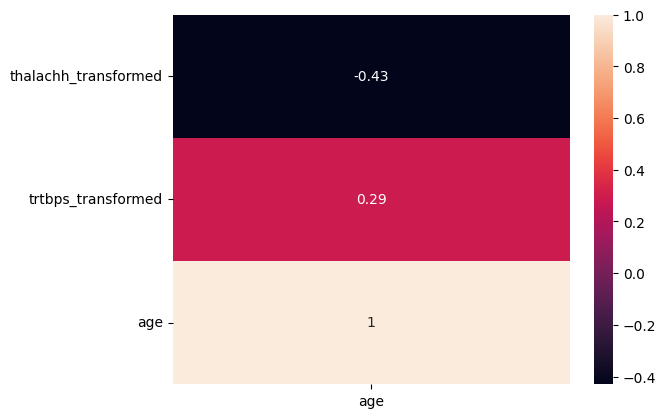

In [45]:
matrix = scaled_data[['thalachh_transformed', 'trtbps_transformed', 'age']]\
            .corr(method='spearman').round(2)
sns.heatmap(matrix[abnormal_features], annot=True)
plt.show()

Aquí sí apreciamos correlaciones más elevadas, especialmente la correlación negativa entre la edad y las pulsaciones maximas (que se antoja razonable) y, en menor medida, la positiva entre la presión y la edad.

A pesar de ello no consideramos que sea suficientemente elevada para justificar la omisión de una de ellas a la hora de entrenar el modelo.

El último análisis estadístico que realizaremos será el ajuste de una regresión logística para la predicción de la variable output.

## Regresión logística

En esta parte de la fase de análisis de datos, queremos probar a realizar una aproximación a un modelo predictivo de la variable *output* a partir de una regresión logística, que nos permita estimar si son buenas candidatas a varibales predictoras. 

Dadas las conclusiones del análisis estadistico por sexo, formará parte de las variables de entrenamiento junto a las 4 variables que hemos trabajado, *age*, *thalachh*, *trtbps* y *chol*.

In [46]:
features = ['age_transformed'] + normal_features + ['sex']

df_new = scaled_data.merge(data[['sex', 'output']], left_index = True, right_index = True)\
            [features + ['output']]
df_new.head()

,age_transformed,thalachh_transformed,chol_transformed,trtbps_transformed,sex,output
0,0.745183,0.426637,0.494965,0.725529,1,1
1,0.063060,0.881933,0.577058,0.516347,1,1
2,0.152474,0.679724,0.343147,0.516347,0,1
3,0.538885,0.757650,0.509793,0.375103,1,1
4,0.567379,0.570074,1.000000,0.375103,0,1


Creamos una función en que realizamos el fit de la regresión logística y generamos las predicciones sobre el conjunto de test. En base a los resultados extraeremos las métricas correspondientes al modelo.

In [47]:
from sklearn.linear_model import LogisticRegression


def predict_on_sex(df_train, features, output, df_test):
    X = df_train[features]
    y = df_train[output]
    
    model = LogisticRegression().fit(X, y)
    
    X_test = df_test[features]
    y_pred = model.predict(df_test[features])
    y_test = df_test[output]
    return X_test, y_test, y_pred, model

### Analisis del modelo

Elegimos la partición para el entrenamiento. El resto de datos se utilizarán como datos de evaluación para calcular las métricas.

In [48]:
train_split = 4 / 5

split_row = int(df_new.shape[0] * train_split)
df_new = df_new.sample(frac = 1, random_state = 1)

X, y, y_pred, model = predict_on_sex(df_new[:split_row], features, 'output', df_new[split_row:])

Generamos las métricas, en este caso una matriz de confusión, la precisión y el recall. El recall es especialmente interesante ya que queremos obtener un modelo capaz de identificar consistentemente la clase positiva (alto riesgo de ataque al corazón).

In [49]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score, roc_curve, RocCurveDisplay

print("Confusion Matrix:")
print(confusion_matrix(y, y_pred))

print("\nMetrics:")
precision = precision_score(y, y_pred)
print("Precision:",round(precision*100,1),"%")
recall = recall_score(y, y_pred)
print("Recall",round(recall*100,1),"%")

Confusion Matrix:
[[13 11]
 [ 6 25]]

Metrics:
Precision: 69.4 %
Recall 80.6 %


Además, visualizamos la curva ROC para dar una idea de la performance del clasificador en general.

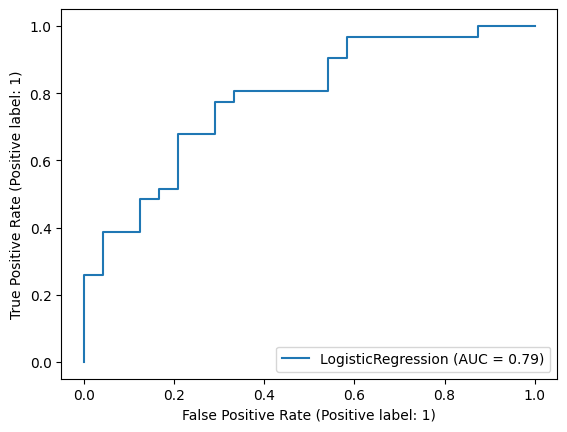

In [50]:
RocCurveDisplay.from_estimator(model, X, y)

Como vemos, el AUC está por encima de 0.5, con lo que estamos mejorando la aleatoreidad. Estos resultados se obtienen con un modelo entrenado con tan solo 5 de las columnas del dataset y sin realizar ningún tipo de optimización de hiperparámetros, por lo que consideramos que las variables que hemos seleccionado, así como su procesamiento han resultado clave para obtener estos resultados.

### Exportamos los datos

In [51]:
scaled_data.columns = scaled_data.columns.str.replace('_transformed', '_scaled')
data.merge(scaled_data[['trtbps_scaled','chol_scaled', 'thalachh_scaled', 'age_scaled']],
           left_index = True, right_index = True).\
            to_csv("datos/processed_data.csv", index=False)

## 5. Representación de los resultados

Se realiza durante toda la práctica.

## 6. Resolución del problema

- Hemos verificado si las distribuciones de las variables numéricas son homogeneas en las diferentes poblaciones por sexo. Para ello hemos utilizado t de Student / Mann Whitney U y hemos obtenido que no hay diferencias estadísticas significativas para las pulsaciones máximas y la presión arterial, pero sí para el colesterol. **Por lo que para un modelo de aprendizaje general que incluya el colesterol debe ir acompañado del sexo, ya que proviene de dos poblaciones diferentes.**

- A través del test de correlación, **hemos concluido que no existen correlaciones suficientemente importantes para reducir la dimensionalidad descartando alguna de las variables numéricas**. Aunque la edad tiene una correlación significativa con el thalachh, creemos que ambas deben formar parte del modelo, ya que en combinación con otras variables puede indicar al modelo patrones específicos asociados con el riesgo que ayuden a mejorar la capacidad de predicción.

- Para verificar la capacidad predictiva de las variables seleccionadas **hemos realizado una regresión logística y hemos obtenido un AUC significativamente superior a la predicción aleatoria**. Creemos que el procesamiento que se ha realizado de los datos desde el tratamiento de outliers hasta las transformaciones y el escalado de variables ha sido clave para obtener estos resultados.

## Firma participantes:

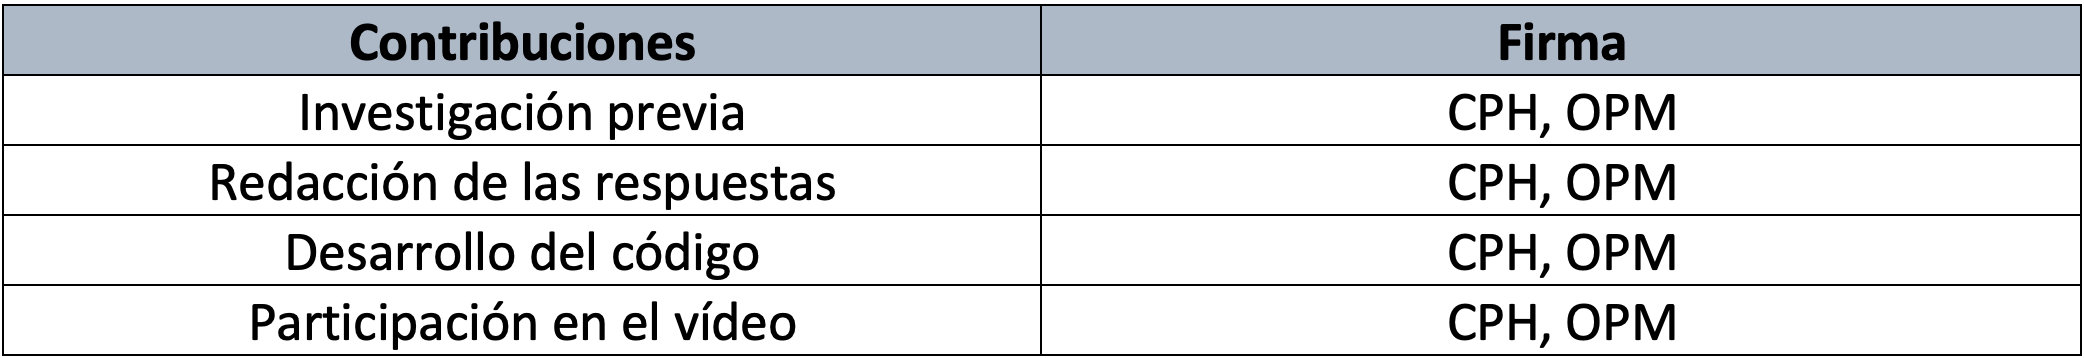